# SCENIC Protocol - Case study - Mouse brain data set


__Author:__ Bram Van de Sande

__Date:__ 15 JUN 2019

__Outline:__ Acquistion and cleaning of selected scRNAseq data sets.

_Experiments:_

| Accession ID | Cancer type | 
| ------------- | ----------- | 
| GSE60361 | Mouse brain |

In [2]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict

import GEOparse

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

from pyscenic.export import export2loom

/home/bramvds/Documents/miniconda3/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
# Set maximum number of jobs
sc.settings.njobs = 32

__GSE60361__

In [143]:
BASE_FOLDERNAME = '/Users/bramvandesande/Projects/lcb/scenic_protocol/datasets/zeisel'

# Downloaded expression matrix from GEO on 13 JUN 2019 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361).
COUNTS_MTX_FNAME = os.path.join(BASE_FOLDERNAME, 'GSE60361_C1-3005-Expression.txt')
# Downloaded metadata from http://linnarssonlab.org/cortex/ on 13 JUN 2019
METADATA_FNAME = os.path.join(BASE_FOLDERNAME, 'expression_mRNA_17-Aug-2014.txt')

# Output file
COUNTS_QC_MTX_FNAME = os.path.join(BASE_FOLDERNAME, 'GSE60361.qc.counts.csv')
MM_TFS_FNAME = os.path.join(BASE_FOLDERNAME, 'mm_tfs.txt')

In [135]:
#Create list of M. musculus transcription factors.

pd_motifs = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/motifs-v9-nr.mgi-m0.001-o0.0.tbl', sep='\t')

/Users/bramvandesande/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
mm_tfs = pd_motifs.gene_name.unique()
len(mm_tfs)

1721

In [144]:
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

In [29]:
df_counts = pd.read_csv(EXPRESSION_MTX_FNAME, sep='\t', index_col=0)
df_counts.shape

(19972, 3005)

In [81]:
df_metadata = pd.read_csv(METADATA_FNAME, sep='\t', index_col=1, nrows=9).drop(columns=['Unnamed: 0']).T.reset_index() #.drop(columns=['index', 'group #'])
df_metadata.columns.name = ''

In [96]:
df_metadata.age = df_metadata.age.astype(int)

In [97]:
df_metadata.head()

,index,group #,total mRNA mol,well,sex,age,diameter,cell_id,level1class,level2class
0,sscortex,1,21580,11,1,21,0,1772071015_C02,interneurons,Int10
1,sscortex.1,1,21748,95,-1,20,9.56,1772071017_G12,interneurons,Int10
2,sscortex.2,1,31642,33,-1,20,11.1,1772071017_A05,interneurons,Int6
3,sscortex.3,1,32916,42,1,21,11.7,1772071014_B06,interneurons,Int10
4,sscortex.4,1,21531,48,1,25,11,1772067065_H06,interneurons,Int9


In [131]:
adata = sc.AnnData(X=df_counts.T.sort_index())
adata.obs = df_metadata.set_index('cell_id').sort_index()
adata.var_names_make_unique
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
df_counts_qc = adata.to_df()
sc.pp.normalize_total(adata, fraction=0.9)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 3005 × 18879 
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells'

In [132]:
df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME)

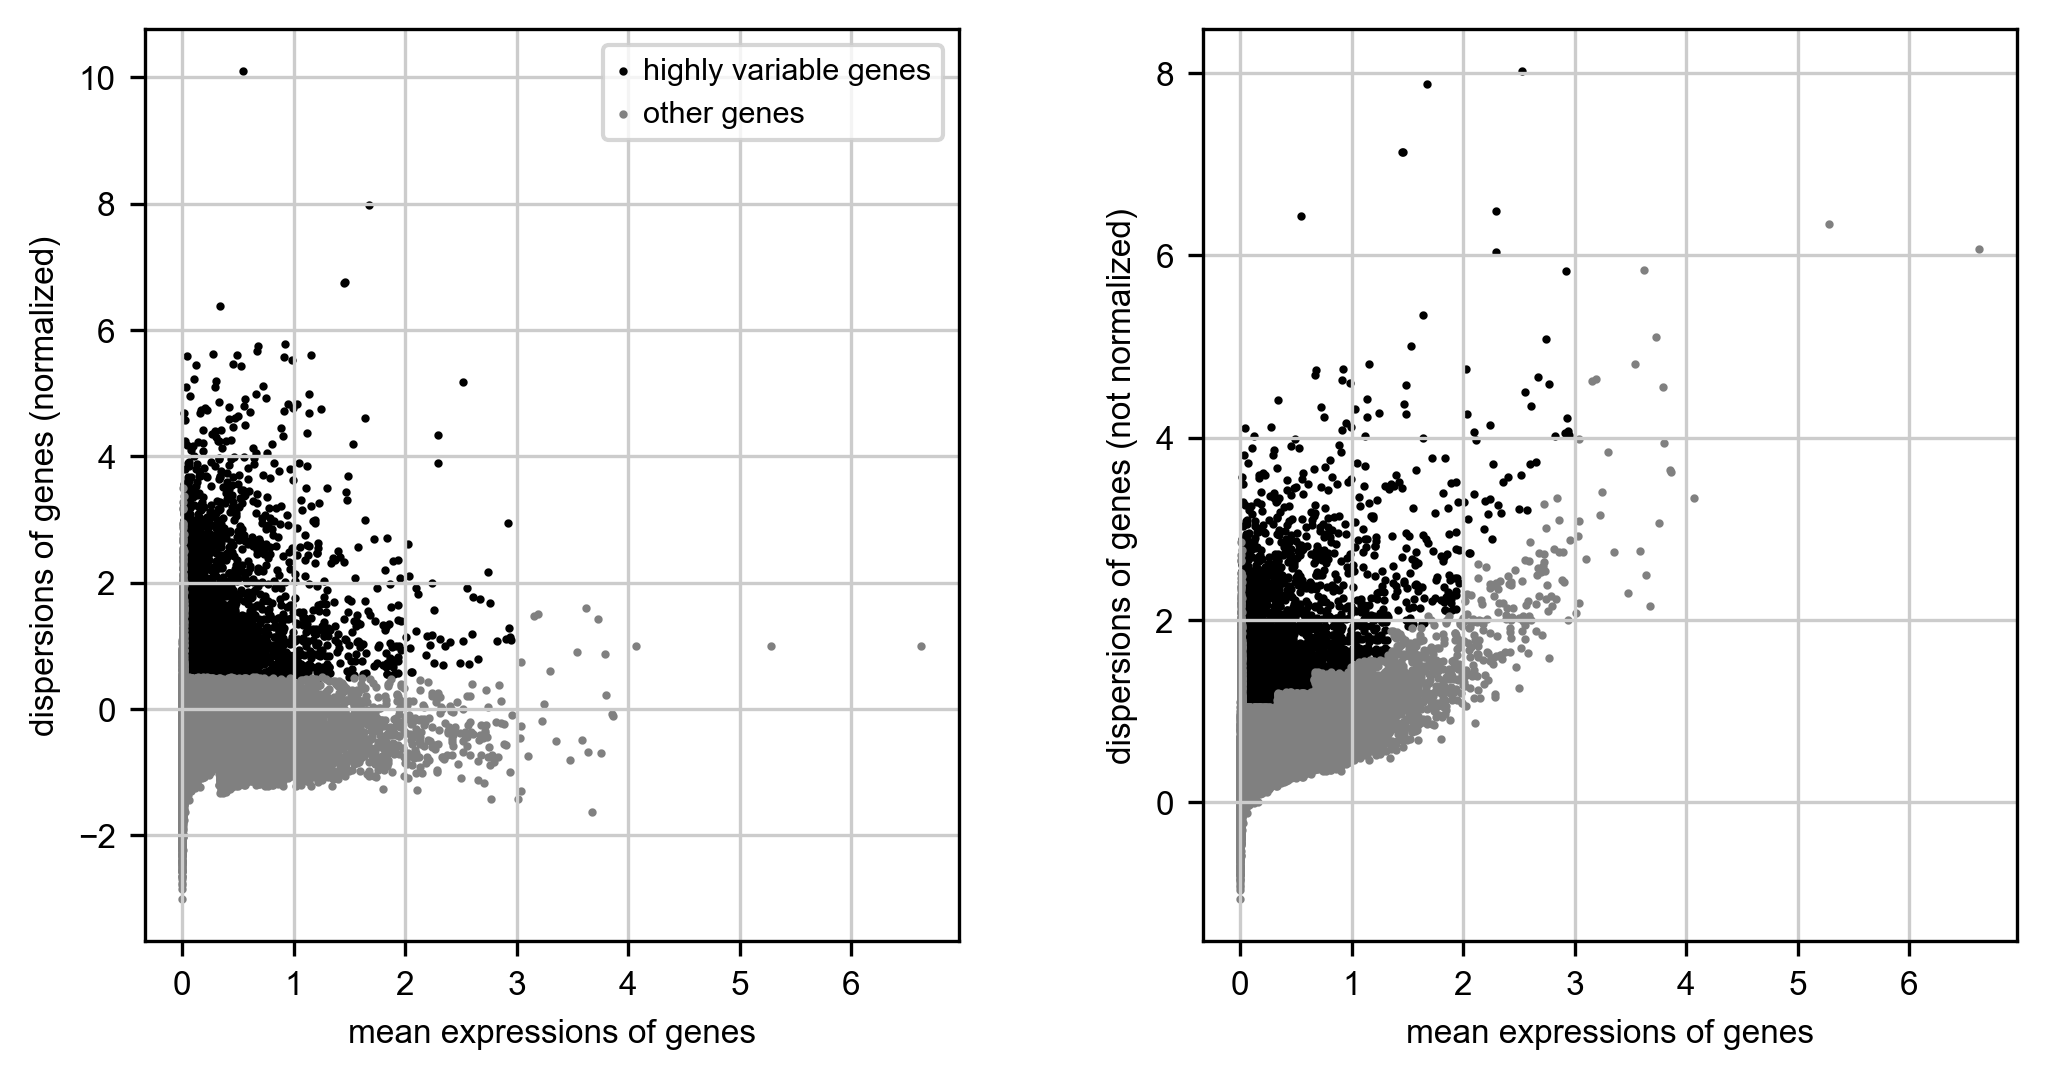

In [114]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [115]:
adata = adata[:, adata.var['highly_variable']]

In [116]:
sc.tl.pca(adata, svd_solver='arpack')

Trying to set attribute `.obsm` of view, making a copy.


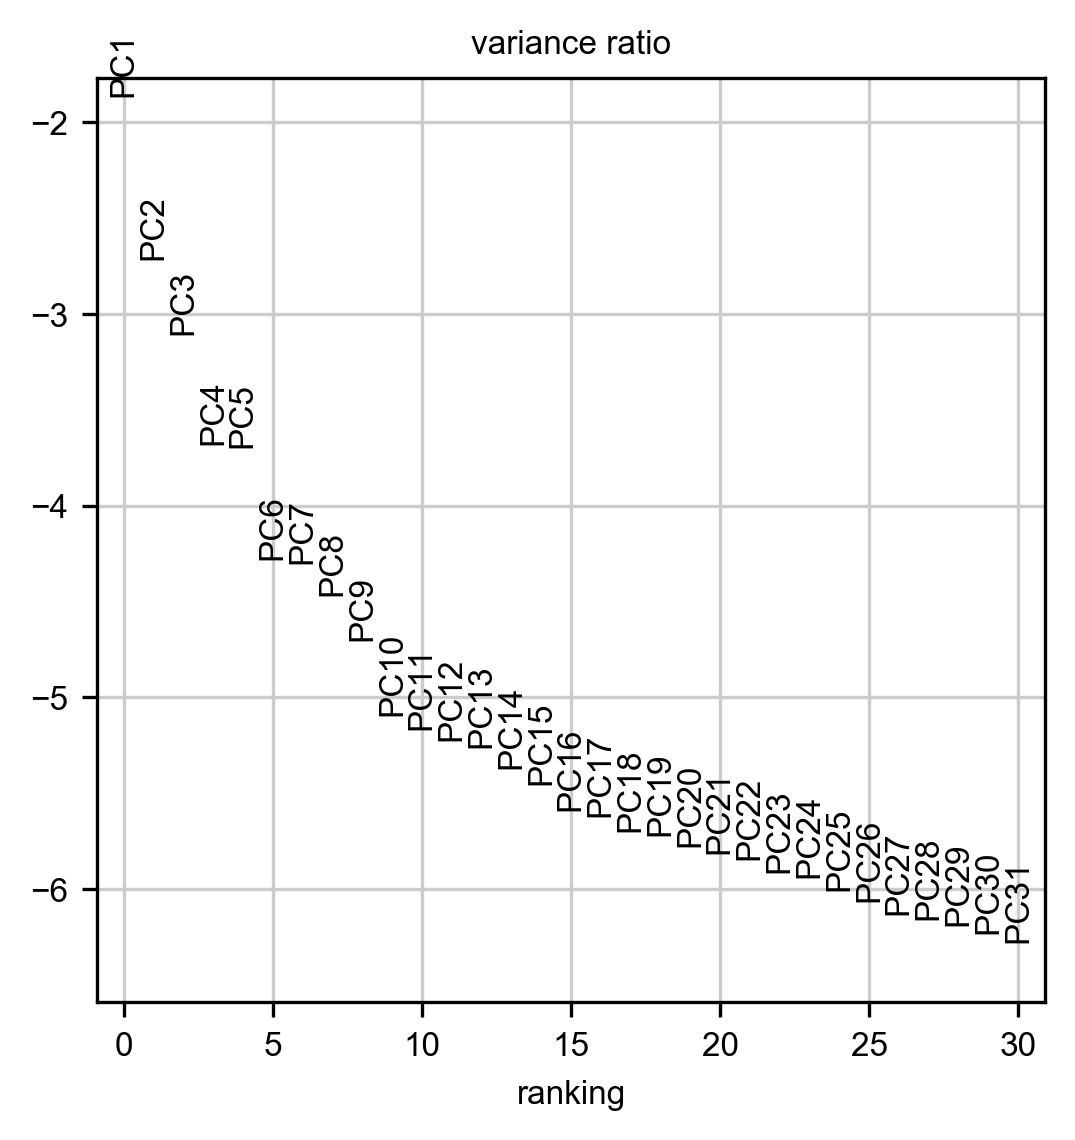

In [117]:
sc.pl.pca_variance_ratio(adata, log=True)

In [118]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.tl.louvain(adata)

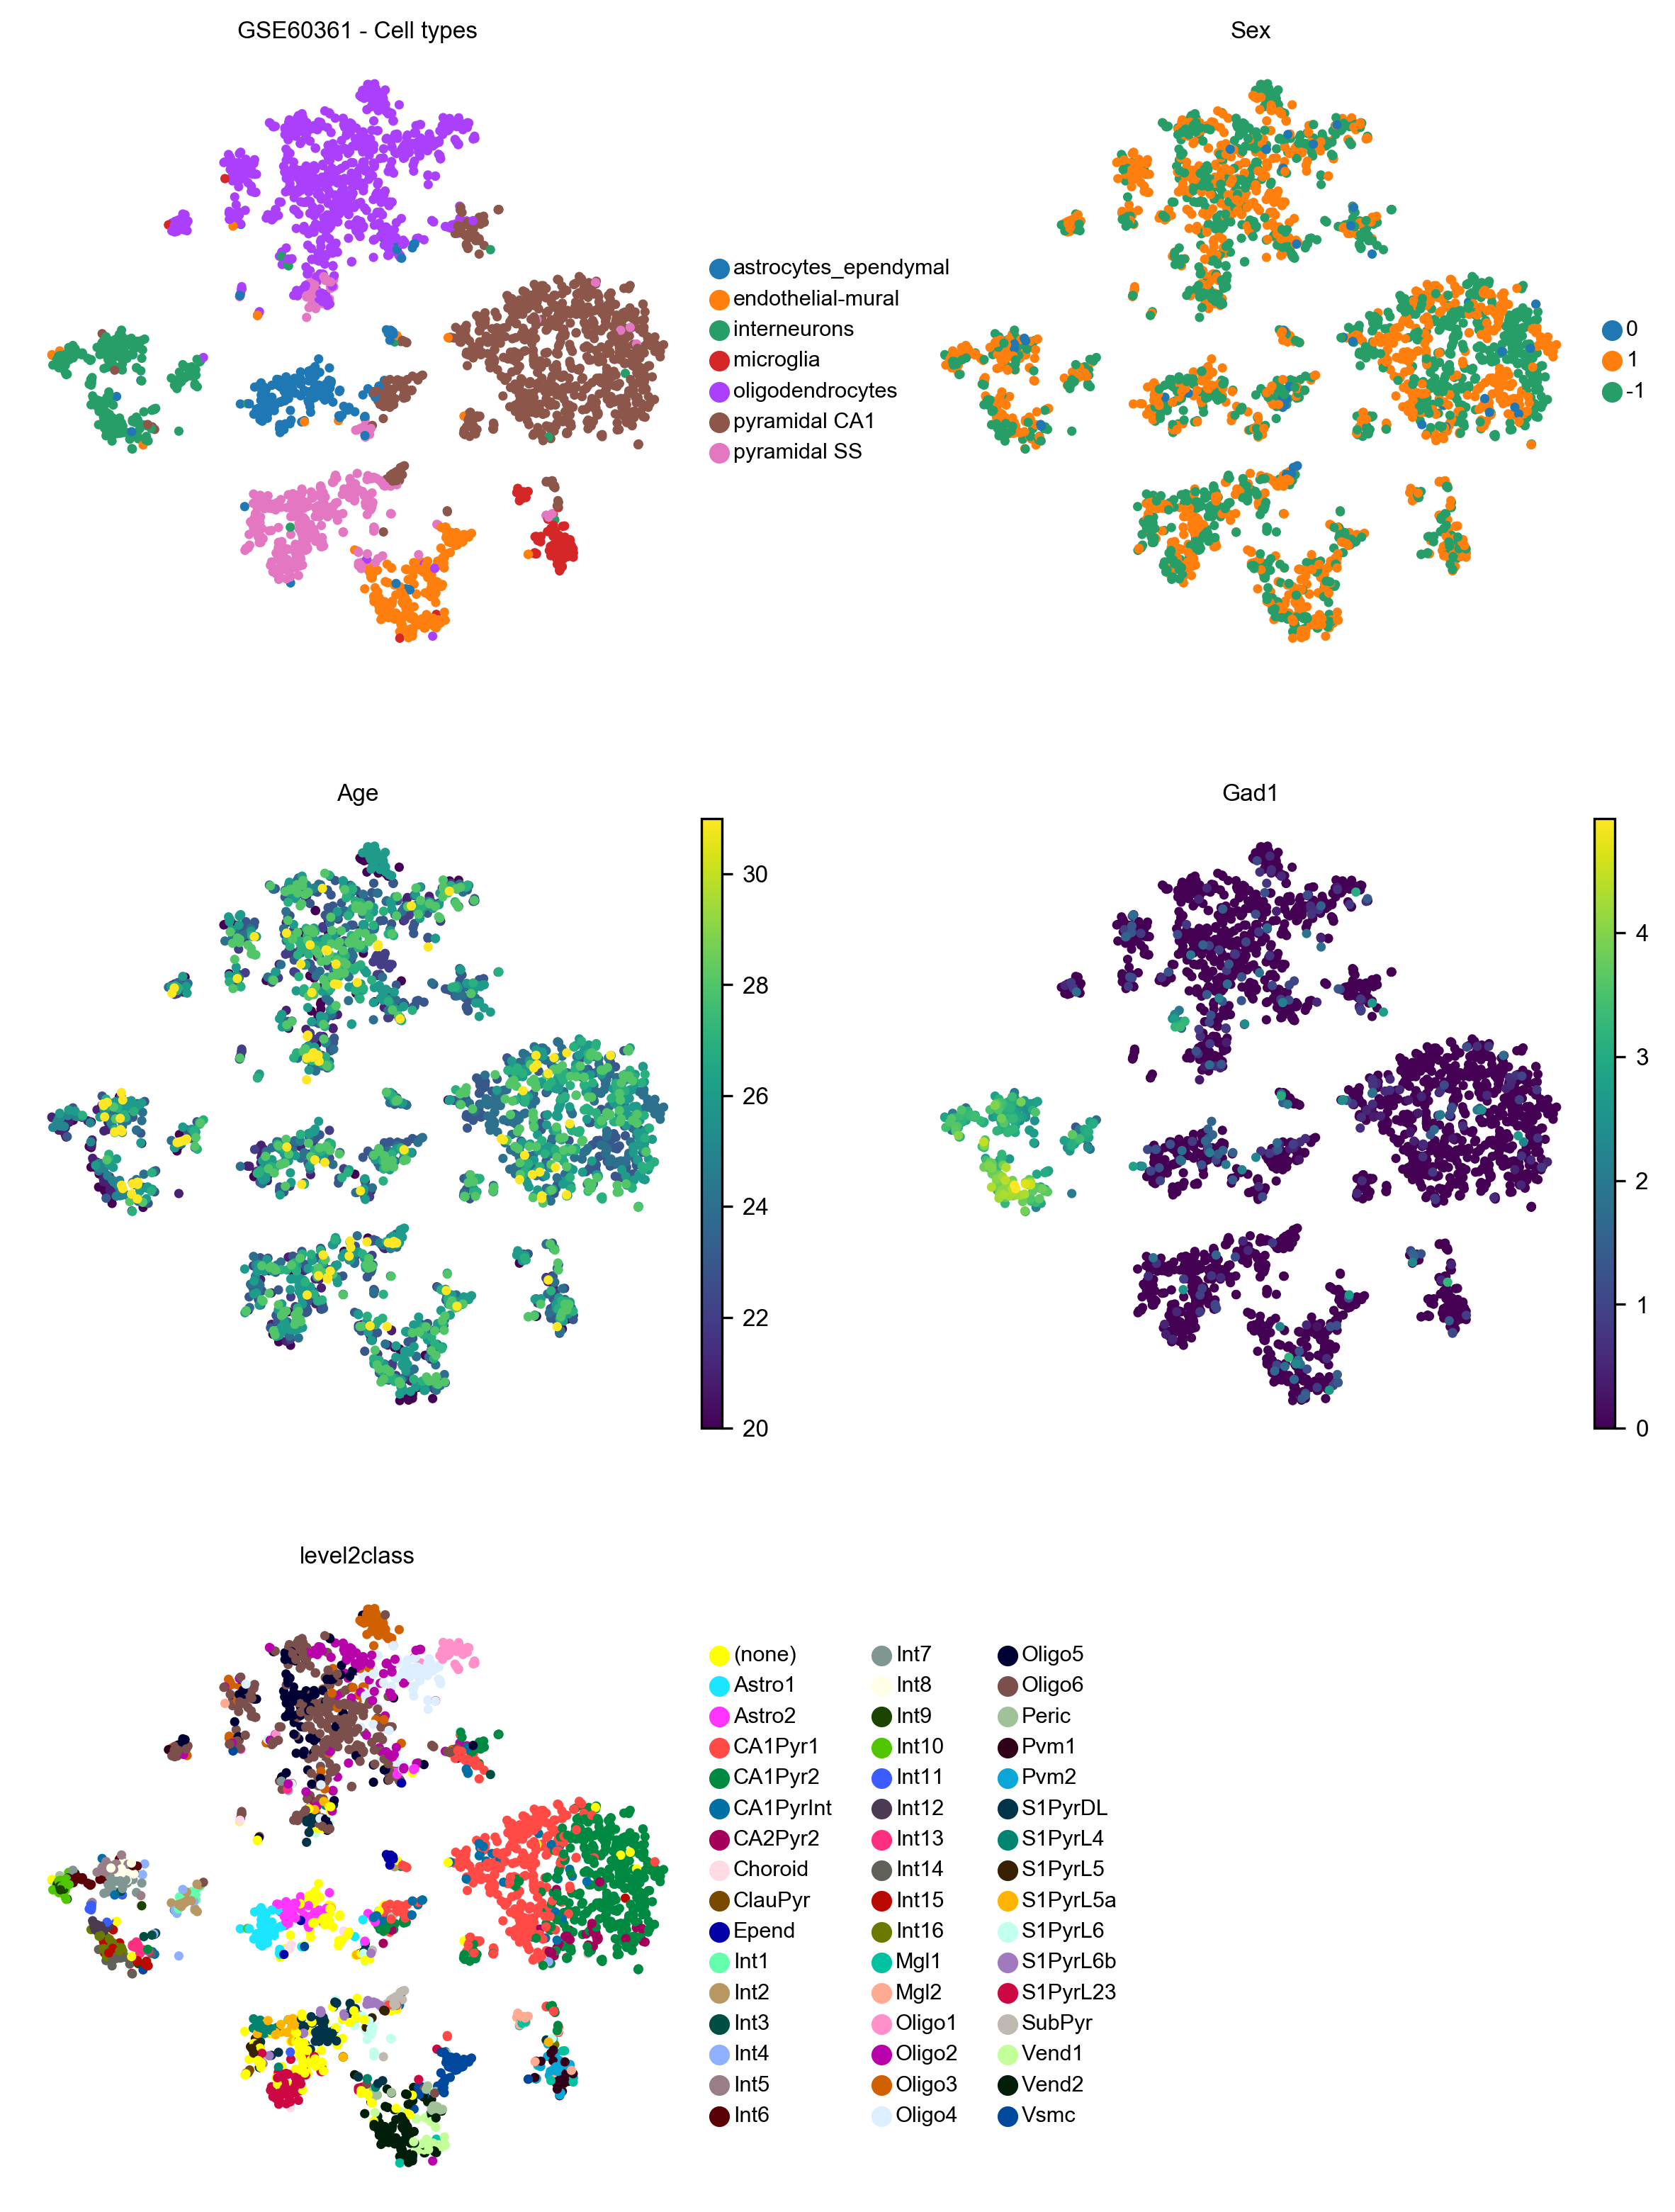

In [129]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['level1class', 'sex', 'age', 'Gad1', 'level2class' ], 
           title=['GSE60361 - Cell types', 'Sex', 'Age', 'Gad1', 'level2class'], ncols=2, use_raw=False)

In [120]:
len(df_metadata.well.unique())

96

In [ ]:
__GSE60361__

```
pyscenic grn GSE60361.qc.counts.csv mm_mgi_tfs.txt -o GSE60361.adjacencies.tsv --num_workers 32
```

```
2019-06-13 17:32:45,044 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.
2019-06-13 17:33:07,766 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
32 partitions
computing dask graph
not shutting down client, client was created externally
finished
2019-06-13 18:04:23,356 - pyscenic.cli.pyscenic - INFO - Writing results to file.

In [ ]:

__GSE60361__

```
pyscenic ctx GSE60361.adjacencies.tsv mm9-500bp-upstream-10species.mc9nr.feather mm9-tss-centered-10kb-10species.mc9nr.feather mm9-tss-centered-5kb-10species.mc9nr.feather --annotations_fname motifs-v9-nr.mgi-m0.001-o0.0.tbl --expression_mtx_fname GSE60361.qc.counts.csv --output GSE60361.motifs.csv --num_workers 32
```

```
2019-06-14 09:49:42,740 - pyscenic.cli.pyscenic - INFO - Creating modules.
2019-06-14 09:49:45,193 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.
2019-06-14 09:52:42,315 - pyscenic.cli.pyscenic - INFO - Loading databases.
2019-06-14 09:52:42,316 - pyscenic.cli.pyscenic - INFO - Calculating regulons.
2019-06-14 10:18:06,172 - pyscenic.cli.pyscenic - INFO - Writing results to file.
```

In [11]:
%%time
auc_mtx = aucell(exp_mtx, regulons, num_workers=32)

CPU times: user 10.5 s, sys: 4.41 s, total: 14.9 s
Wall time: 14 s
